In [2]:
import torch
import pandas as pd
import os
import time
import cv2 as cv
from PIL import Image
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

## 参数

In [3]:
photo_path = './data/photo_jpg'
monet_path = './data/monet_jpg'

BATCH_SIZE = 16
LR_RATE = 1E-4

## 查看图片

### 原图

In [4]:
img_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(photo_path)))]
print(img_names[:10])

img_path = os.path.join(photo_path, img_names[1])
print(img_path)

img = Image.open(img_path)
# img.show()

['00068bc07f.jpg', '000910d219.jpg', '000ded5c41.jpg', '00104fd531.jpg', '001158d595.jpg', '0033c5f971.jpg', '0039ebb598.jpg', '003aab6fdd.jpg', '003c6c30e0.jpg', '00479e2a21.jpg']
./data/photo_jpg\000910d219.jpg


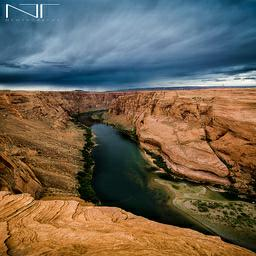

In [5]:
img

## 创建数据集

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.


In [6]:
class MonetDataset(Dataset):
    def __init__(self, data_path, transform):
        
        self.data_path = data_path
        self.transform = transform
        self.img_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(self.data_path)))]

    def __getitem__(self, index):
        img_path = os.path.join(self.data_path, self.img_names[index])
        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        if len(self.img_names) == 0:
            raise Exception(f"\ndata_path: {self.data_path} is an empty dir! Please checkout your path!")
        return len(self.img_names)

In [7]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.4038, 0.4086, 0.3840], std=[0.2219, 0.2027, 0.2198])
#     transforms.Lambda(lambda x: (x / 127.5) - 1)
# ])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

photo_dataset = MonetDataset(photo_path, transform)
dataloader_photo = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'BATCH_SZIE: {BATCH_SIZE}, len(photo_dataset): {len(photo_dataset)}, len(dataloader_photo): {len(dataloader_photo)}')
print(f'photo_dataset[0].shape: {photo_dataset[0].shape}')

monet_dataset = MonetDataset(monet_path, transform)
dataloader_monet = DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'len(monet_dataset): {len(monet_dataset)}, len(dataloader_monet): {len(dataloader_monet)}')
print(f'monet_dataset[0].shape: {monet_dataset[0].shape}')

BATCH_SZIE: 16, len(photo_dataset): 7038, len(dataloader_photo): 440
photo_dataset[0].shape: torch.Size([3, 256, 256])
len(monet_dataset): 300, len(dataloader_monet): 19
monet_dataset[0].shape: torch.Size([3, 256, 256])


## 构建模型

In [10]:
class Down(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)
    
class Up(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU() # inplace会覆盖原内存
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator, self).__init__()  
        # input size: [bs, 3, 256, 256], bs = batch size
        self.down1 = Down(in_channel, 64)   # [bs, 64, 128, 128]
        self.down2 = Down(64, 128)          # [bs, 128, 64, 64]
        self.down3 = Down(128, 256)          # [bs, 256, 32, 32]
        self.down4 = Down(256, 512)         # [bs, 512, 16, 16]
        self.down5 = Down(512, 1024)        # [bs, 1024, 8, 8]
        self.down6 = Down(1024, 1024)       # [bs, 1024, 4, 4]

        self.down = nn.Sequential(
            Down(in_channel, 64), # [bs, 64, 128, 128]
            Down(64,  128),       # [bs, 128, 64, 64]
            Down(128, 256),       # [bs, 256, 32, 32]
            Down(256, 512),       # [bs, 512, 16, 16]
            Down(512, 1024),      # [bs, 1024, 8, 8]
            Down(1024, 1024)      # [bs, 1024, 4, 4]
        )

        self.fc = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x1 = self.down(x)
        out = self.fc(x1.view(x1.size(0), -1))

        return out

class Generator(nn.Module):
    def __init__(self, latent_dim, num_fea=16384, normalize=True):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.normalize = normalize

        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, 
                                         kernel_size, stride, padding=1)]
            if self.normalize:
                layers.append(nn.BatchNorm2d(out_channels))

            layers.append(nn.ReLU())

            return layers
    
        self.model = nn.Sequential(
            # input: [bs, 1024, 4, 4]
            *block(1024, 512),   # [bs, 512, 8, 8]
            *block(512, 256),    # [bs, 256, 16, 16]
            *block(256, 128),    # [bs, 128, 32, 32]
            *block(128, 64),     # [bs, 64, 64, 64]
            *block(64, 32),      # [bs, 32, 128, 128]
            *block(32, 3)        # [bs, 3, 256, 256]
        )

        self.fc0 = nn.Linear(latent_dim, num_fea)

    def forward(self, z):
        # input: [bs, latent_dim]
        img = self.fc0(z)  # [bs, 16384]
        img = img.view(img.size(0), 1024, 4, 4) # [bs, 1024, 4, 4]
        img = self.model(img)

        return img

## 训练模型

In [14]:
img_shape = tuple(photo_dataset[0].shape)
print(f'img_shape: {img_shape}')

latent_dim = 100
normalize_flag = True
EPOCHS = 20

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Loss function
adversarial_loss = nn.BCELoss()

generator = Generator(latent_dim)
discriminator = Discriminator(img_shape[0])

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR_RATE)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR_RATE)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

img_shape: (3, 256, 256)
Device: cuda


In [19]:
valid = Variable(Tensor(3, 1).fill_(1.0), requires_grad=False).to(device)
valid

tensor([[1.],
        [1.],
        [1.]], device='cuda:0')

In [15]:
dataloader = dataloader_photo
for epoch in range(EPOCHS):
    for i, imgs in enumerate(dataloader):
        
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        
        real_imgs = Variable(imgs.type(Tensor)).to(device)
        
        # Train Generator
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim)))).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)
        
        # loss
        aa = discriminator(gen_imgs)
        g_loss = adversarial_loss(aa, valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        
        bb = discriminator(real_imgs)
        real_loss = adversarial_loss(bb, valid)

        # Measure discriminator's ability to classify real from generated samples
        bb = discriminator(real_imgs)
        real_loss = adversarial_loss(bb, valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 10 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, EPOCHS, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 100 == 0:
            save_image(gen_imgs.data[:25], "result/%d.png" % batches_done, nrow=5, normalize=True)

torch.save(generator.state_dict, 
            f'result/saved_models/Generator_GAN_{time.strftime("%Y%m%d_%H%M%S", time.localtime())}')

torch.save(discriminator.state_dict, 
            f'result/saved_models/Discriminator_GAN_{time.strftime("%Y%m%d_%H%M%S", time.localtime())}')

[Epoch 0/20] [Batch 0/440] [D loss: 1.021341] [G loss: 1.963759]
[Epoch 0/20] [Batch 1/440] [D loss: 0.758140] [G loss: 0.372849]
[Epoch 0/20] [Batch 2/440] [D loss: 0.675539] [G loss: 0.726444]
[Epoch 0/20] [Batch 3/440] [D loss: 0.731114] [G loss: 1.110686]
[Epoch 0/20] [Batch 4/440] [D loss: 0.898794] [G loss: 0.230265]
[Epoch 0/20] [Batch 5/440] [D loss: 0.954700] [G loss: 1.779232]
[Epoch 0/20] [Batch 6/440] [D loss: 0.736720] [G loss: 0.410609]
[Epoch 0/20] [Batch 7/440] [D loss: 0.676833] [G loss: 0.634238]
[Epoch 0/20] [Batch 8/440] [D loss: 0.770987] [G loss: 1.286961]
[Epoch 0/20] [Batch 9/440] [D loss: 1.145968] [G loss: 0.120387]
[Epoch 0/20] [Batch 10/440] [D loss: 1.173729] [G loss: 2.327042]
[Epoch 0/20] [Batch 11/440] [D loss: 0.743478] [G loss: 0.393609]
[Epoch 0/20] [Batch 12/440] [D loss: 0.697335] [G loss: 0.523695]
[Epoch 0/20] [Batch 13/440] [D loss: 0.919714] [G loss: 1.717743]
[Epoch 0/20] [Batch 14/440] [D loss: 0.985279] [G loss: 0.180182]
[Epoch 0/20] [Batch 

## 参考资料：
[1] [用GAN训练自己的数据生成新的图片](https://blog.csdn.net/qq_36563273/article/details/119325318) <br>
[2] [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Introduction-and-Setup) <br>
[3] [比赛官网](https://www.kaggle.com/competitions/gan-getting-started/overview)